# Feature Importance Analysis (SHAP) - PRE-decision

**Purpose**: Identify which specific gaze/pupil features drive predictions in the PRE-decision window (-2 to 0 seconds before submit).

**Method**: SHAP (SHapley Additive exPlanations) values for Random Forest models

**Deliverable**: Top 10 features with SHAP importance scores

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneGroupOut
import shap

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

/Users/pranmodu/Projects/columbia/liinc/liinc_venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load PRE-decision Features

In [2]:
# Load features
with open('../../data/results/features_PRE/extracted_features_PRE.pkl', 'rb') as f:
    feature_data = pickle.load(f)

data = feature_data['merged_df']

print(f"Total trials: {len(data)}")
print(f"Subjects: {data['subject_id'].nunique()}")
print(f"Outcome distribution: {data['outcome'].value_counts().to_dict()}")

Total trials: 12511
Subjects: 97
Outcome distribution: {1: 8238, 0: 4273}


## Prepare Data

We'll analyze three modalities separately:
1. **Physiology (Pupil)**: 13 features
2. **Gaze**: 20 features  
3. **Combined**: All physiology + gaze features

In [3]:
# Define feature groups (with _pre suffix)
physiology_features = [
    'pupil_mean_pre', 'pupil_std_pre', 'pupil_slope_pre', 'time_to_peak_pre', 
    'pupil_cv_pre', 'pupil_velocity_mean_pre', 'pupil_max_dilation_rate_pre',
    'pupil_max_constriction_rate_pre', 'pupil_acceleration_std_pre',
    'pct_time_dilating_pre', 'num_dilation_peaks_pre', 'eye_asymmetry_pre', 
    'eye_asymmetry_std_pre'
]

gaze_features = [
    'gaze_valid_pct', 'gaze_x_mean', 'gaze_x_std', 'gaze_y_mean', 'gaze_y_std',
    'screen_x_mean', 'screen_x_std', 'screen_y_mean', 'screen_y_std',
    'gaze_velocity_mean', 'gaze_velocity_std', 'gaze_velocity_max',
    'gaze_acceleration_mean', 'gaze_acceleration_std',
    'fixation_ratio', 'saccade_ratio', 'saccade_count',
    'gaze_dispersion_x', 'gaze_dispersion_y', 'gaze_path_length'
]

behavior_features = [
    'reaction_time', 'decision_time', 'ev_difference',
    'invest_variance', 'ambiguity', 'condition_social', 'risk_premium'
]

# Verify all features exist
available_physiology = [f for f in physiology_features if f in data.columns]
available_gaze = [f for f in gaze_features if f in data.columns]

print(f"Physiology features: {len(available_physiology)}/{len(physiology_features)}")
print(f"Gaze features: {len(available_gaze)}/{len(gaze_features)}")

# Prepare datasets
X_physiology = data[available_physiology].values
X_gaze = data[available_gaze].values
X_combined = data[available_physiology + available_gaze].values
y = data['outcome'].values
subjects = data['subject_id'].values

Physiology features: 13/13
Gaze features: 20/20


## Train Models with LOSO Cross-Validation

We'll use Leave-One-Subject-Out cross-validation to get representative SHAP values across all subjects.

In [4]:
def train_and_get_shap(X, y, subjects, feature_names, model_name="Model"):
    """
    Train RF model with LOSO CV and compute SHAP values.
    
    Returns:
    - shap_values: SHAP values for all test samples
    - feature_importance_df: DataFrame with feature importance scores
    """
    print(f"\n{'='*60}")
    print(f"Computing SHAP values for {model_name}")
    print(f"{'='*60}")
    print(f"Input X shape: {X.shape}")
    print(f"Number of feature names: {len(feature_names)}")
    
    logo = LeaveOneGroupOut()
    
    # Store SHAP values for all test samples
    all_shap_values = []
    all_test_indices = []
    
    # Model parameters (same as in late fusion)
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=5,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    )
    
    # LOSO cross-validation
    fold_count = 0
    for fold_idx, (train_idx, test_idx) in enumerate(logo.split(X, y, subjects)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train = y[train_idx]
        
        # Train model
        rf.fit(X_train, y_train)
        
        # Compute SHAP values for this fold
        explainer = shap.TreeExplainer(rf)
        shap_values_fold = explainer.shap_values(X_test)
        
        # Handle different SHAP output formats
        if isinstance(shap_values_fold, list):
            # Binary classification - take class 1 (INVEST)
            shap_values_fold = shap_values_fold[1]
        
        # If still 3D (samples, features, classes), take the last dimension
        if len(shap_values_fold.shape) == 3:
            shap_values_fold = shap_values_fold[:, :, 1]  # Take class 1
        
        # Ensure 2D array
        if len(shap_values_fold.shape) == 1:
            shap_values_fold = shap_values_fold.reshape(1, -1)
        
        all_shap_values.append(shap_values_fold)
        all_test_indices.extend(test_idx)
        
        fold_count += 1
        if fold_count % 20 == 0:
            print(f"  Processed {fold_count} folds...")
    
    # Concatenate all SHAP values
    shap_values_array = np.vstack(all_shap_values)
    
    print(f"\n  SHAP array shape: {shap_values_array.shape}")
    print(f"  Expected: ({len(all_test_indices)}, {len(feature_names)})")
    
    # Compute mean absolute SHAP values for each feature
    mean_abs_shap = np.abs(shap_values_array).mean(axis=0)
    
    print(f"  Mean absolute SHAP shape: {mean_abs_shap.shape}")
    print(f"  Mean absolute SHAP length: {len(mean_abs_shap)}")
    print(f"  Feature names length: {len(feature_names)}")
    
    # Ensure mean_abs_shap is 1D
    if len(mean_abs_shap.shape) > 1:
        mean_abs_shap = mean_abs_shap.flatten()
    
    # Double check lengths match
    if len(mean_abs_shap) != len(feature_names):
        raise ValueError(f"Mismatch: {len(mean_abs_shap)} SHAP values but {len(feature_names)} feature names. "
                        f"X has {X.shape[1]} features.")
    
    # Create feature importance DataFrame
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'mean_abs_shap': mean_abs_shap
    }).sort_values('mean_abs_shap', ascending=False)
    
    print(f"\n✓ SHAP computation complete for {model_name}")
    print(f"  Total samples: {shap_values_array.shape[0]}")
    print(f"  Total features: {shap_values_array.shape[1]}")
    
    return shap_values_array, feature_importance_df, X[all_test_indices]

## 1. Physiology (Pupil) Features

In [5]:
shap_values_phys, importance_phys, X_test_phys = train_and_get_shap(
    X_physiology, y, subjects, available_physiology, "Physiology (Pupil)"
)

print("\nTop 10 Physiology Features:")
print(importance_phys.head(10).to_string(index=False))


Computing SHAP values for Physiology (Pupil)
Input X shape: (12511, 13)
Number of feature names: 13
  Processed 20 folds...
  Processed 40 folds...
  Processed 60 folds...
  Processed 80 folds...

  SHAP array shape: (12511, 13)
  Expected: (12511, 13)
  Mean absolute SHAP shape: (13,)
  Mean absolute SHAP length: 13
  Feature names length: 13

✓ SHAP computation complete for Physiology (Pupil)
  Total samples: 12511
  Total features: 13

Top 10 Physiology Features:
                        feature  mean_abs_shap
                pupil_slope_pre       0.028481
                  pupil_std_pre       0.014047
               time_to_peak_pre       0.011070
          pct_time_dilating_pre       0.010382
                   pupil_cv_pre       0.007723
    pupil_max_dilation_rate_pre       0.004330
        pupil_velocity_mean_pre       0.003498
pupil_max_constriction_rate_pre       0.003400
          eye_asymmetry_std_pre       0.002818
     pupil_acceleration_std_pre       0.002795


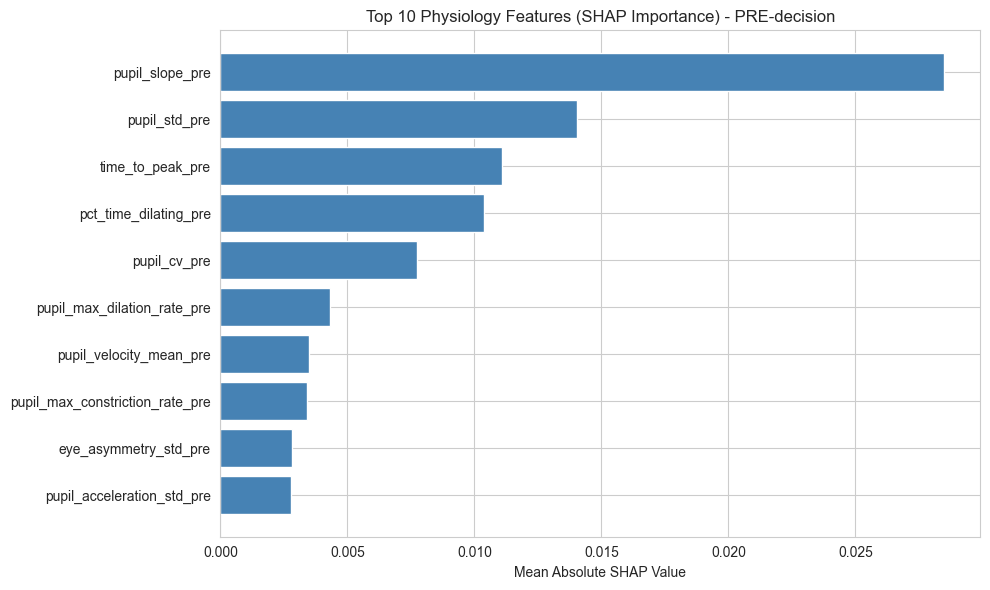

In [6]:
# Visualization: Bar plot of top 10 features
fig, ax = plt.subplots(figsize=(10, 6))
top_10_phys = importance_phys.head(10)
ax.barh(range(len(top_10_phys)), top_10_phys['mean_abs_shap'], color='steelblue')
ax.set_yticks(range(len(top_10_phys)))
ax.set_yticklabels(top_10_phys['feature'])
ax.invert_yaxis()
ax.set_xlabel('Mean Absolute SHAP Value')
ax.set_title('Top 10 Physiology Features (SHAP Importance) - PRE-decision')
plt.tight_layout()
plt.savefig('../../data/results/analysis_outputs_PRE/shap_physiology_top10_PRE.png', dpi=300, bbox_inches='tight')
plt.show()

## 2. Gaze Features

In [7]:
shap_values_gaze, importance_gaze, X_test_gaze = train_and_get_shap(
    X_gaze, y, subjects, available_gaze, "Gaze"
)

print("\nTop 10 Gaze Features:")
print(importance_gaze.head(10).to_string(index=False))


Computing SHAP values for Gaze
Input X shape: (12511, 20)
Number of feature names: 20
  Processed 20 folds...
  Processed 40 folds...
  Processed 60 folds...
  Processed 80 folds...

  SHAP array shape: (12511, 20)
  Expected: (12511, 20)
  Mean absolute SHAP shape: (20,)
  Mean absolute SHAP length: 20
  Feature names length: 20

✓ SHAP computation complete for Gaze
  Total samples: 12511
  Total features: 20

Top 10 Gaze Features:
              feature  mean_abs_shap
     gaze_path_length       0.019190
    gaze_dispersion_x       0.010872
        screen_y_mean       0.010543
           gaze_x_std       0.005758
          gaze_x_mean       0.005729
    gaze_dispersion_y       0.004790
          gaze_y_mean       0.004753
gaze_acceleration_std       0.004266
           gaze_y_std       0.004123
    gaze_velocity_std       0.003810


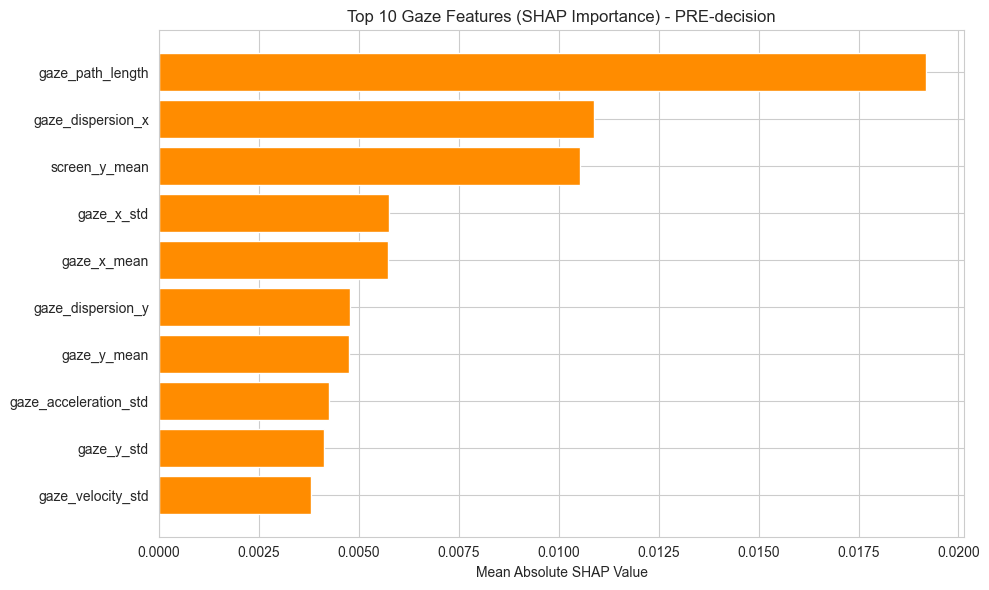

In [8]:
# Visualization: Bar plot of top 10 gaze features
fig, ax = plt.subplots(figsize=(10, 6))
top_10_gaze = importance_gaze.head(10)
ax.barh(range(len(top_10_gaze)), top_10_gaze['mean_abs_shap'], color='darkorange')
ax.set_yticks(range(len(top_10_gaze)))
ax.set_yticklabels(top_10_gaze['feature'])
ax.invert_yaxis()
ax.set_xlabel('Mean Absolute SHAP Value')
ax.set_title('Top 10 Gaze Features (SHAP Importance) - PRE-decision')
plt.tight_layout()
plt.savefig('../../data/results/analysis_outputs_PRE/shap_gaze_top10_PRE.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Combined (Physiology + Gaze) Features

In [9]:
shap_values_combined, importance_combined, X_test_combined = train_and_get_shap(
    X_combined, y, subjects, available_physiology + available_gaze, "Combined (Physiology + Gaze)"
)

print("\nTop 20 Combined Features:")
print(importance_combined.head(20).to_string(index=False))


Computing SHAP values for Combined (Physiology + Gaze)
Input X shape: (12511, 33)
Number of feature names: 33
  Processed 20 folds...
  Processed 40 folds...
  Processed 60 folds...
  Processed 80 folds...

  SHAP array shape: (12511, 33)
  Expected: (12511, 33)
  Mean absolute SHAP shape: (33,)
  Mean absolute SHAP length: 33
  Feature names length: 33

✓ SHAP computation complete for Combined (Physiology + Gaze)
  Total samples: 12511
  Total features: 33

Top 20 Combined Features:
                        feature  mean_abs_shap
                pupil_slope_pre       0.022632
                  pupil_std_pre       0.010518
               time_to_peak_pre       0.008422
               gaze_path_length       0.008421
          pct_time_dilating_pre       0.008055
                  screen_y_mean       0.006087
                   pupil_cv_pre       0.004925
              gaze_dispersion_x       0.004519
                     gaze_x_std       0.003829
                    gaze_y_mean       0.

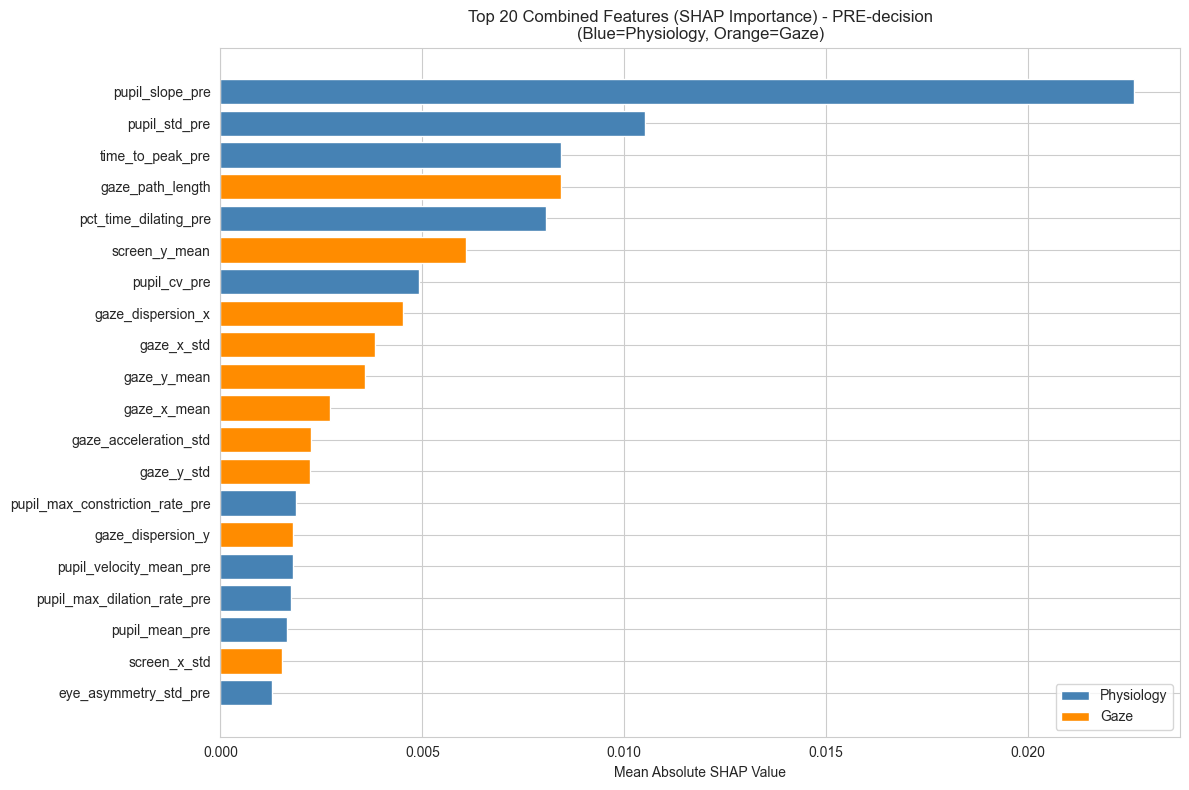

In [10]:
# Visualization: Bar plot of top 20 combined features
fig, ax = plt.subplots(figsize=(12, 8))
top_20_combined = importance_combined.head(20)
colors = ['steelblue' if f in available_physiology else 'darkorange' for f in top_20_combined['feature']]
ax.barh(range(len(top_20_combined)), top_20_combined['mean_abs_shap'], color=colors)
ax.set_yticks(range(len(top_20_combined)))
ax.set_yticklabels(top_20_combined['feature'])
ax.invert_yaxis()
ax.set_xlabel('Mean Absolute SHAP Value')
ax.set_title('Top 20 Combined Features (SHAP Importance) - PRE-decision\n(Blue=Physiology, Orange=Gaze)')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='steelblue', label='Physiology'),
    Patch(facecolor='darkorange', label='Gaze')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig('../../data/results/analysis_outputs_PRE/shap_combined_top20_PRE.png', dpi=300, bbox_inches='tight')
plt.show()

## SHAP Summary Plots

These plots show the distribution of SHAP values for each feature across all samples.

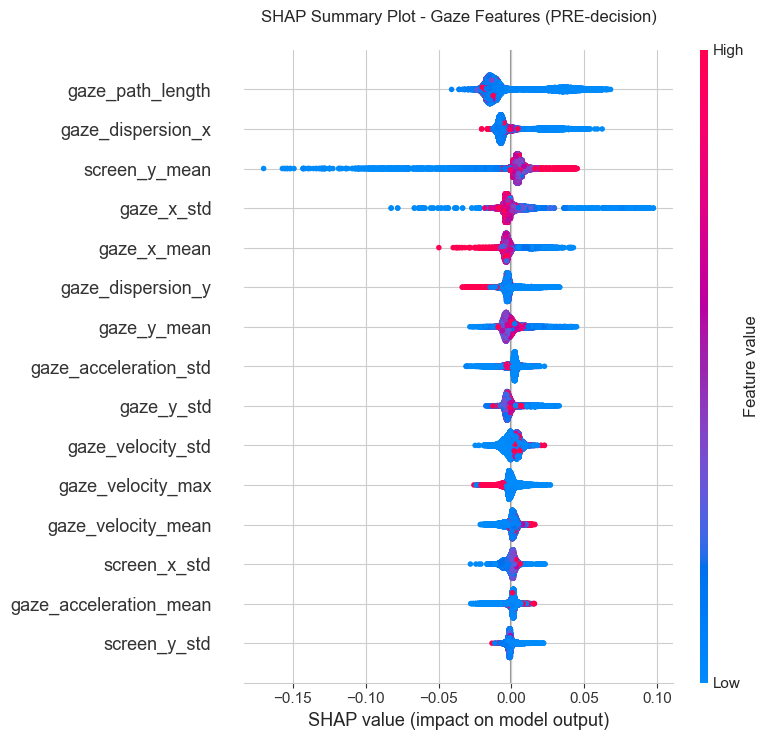

In [11]:
# SHAP summary plot for gaze features (top 15)
fig = plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values_gaze, 
    X_test_gaze, 
    feature_names=available_gaze,
    max_display=15,
    show=False
)
plt.title('SHAP Summary Plot - Gaze Features (PRE-decision)', pad=20)
plt.tight_layout()
plt.savefig('../../data/results/analysis_outputs_PRE/shap_summary_gaze_PRE.png', dpi=300, bbox_inches='tight')
plt.show()

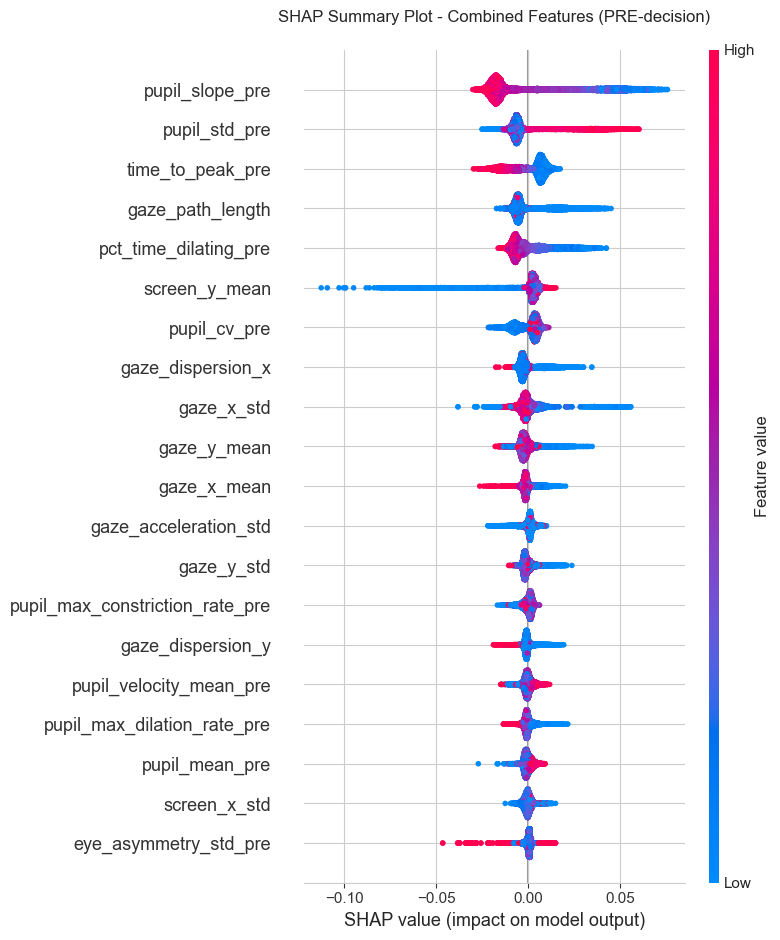

In [12]:
# SHAP summary plot for combined features (top 20)
fig = plt.figure(figsize=(10, 10))
shap.summary_plot(
    shap_values_combined, 
    X_test_combined, 
    feature_names=available_physiology + available_gaze,
    max_display=20,
    show=False
)
plt.title('SHAP Summary Plot - Combined Features (PRE-decision)', pad=20)
plt.tight_layout()
plt.savefig('../../data/results/analysis_outputs_PRE/shap_summary_combined_PRE.png', dpi=300, bbox_inches='tight')
plt.show()

## Save Results

In [13]:
# Save feature importance tables
output_dir = Path('../../data/results/analysis_outputs_PRE')
output_dir.mkdir(parents=True, exist_ok=True)

# Save to CSV
importance_phys.to_csv(output_dir / 'shap_importance_physiology_PRE.csv', index=False)
importance_gaze.to_csv(output_dir / 'shap_importance_gaze_PRE.csv', index=False)
importance_combined.to_csv(output_dir / 'shap_importance_combined_PRE.csv', index=False)

print("\n✓ Feature importance tables saved to:")
print(f"  - {output_dir / 'shap_importance_physiology_PRE.csv'}")
print(f"  - {output_dir / 'shap_importance_gaze_PRE.csv'}")
print(f"  - {output_dir / 'shap_importance_combined_PRE.csv'}")


✓ Feature importance tables saved to:
  - ../../data/results/analysis_outputs_PRE/shap_importance_physiology_PRE.csv
  - ../../data/results/analysis_outputs_PRE/shap_importance_gaze_PRE.csv
  - ../../data/results/analysis_outputs_PRE/shap_importance_combined_PRE.csv


## Summary

### Key Findings:

**Top 10 Features Overall (Combined Model):**

In [14]:
# Print formatted summary
print("\n" + "="*60)
print("TOP 10 FEATURES DRIVING PRE-DECISION PREDICTIONS")
print("="*60)

top_10_overall = importance_combined.head(10).copy()
top_10_overall['modality'] = top_10_overall['feature'].apply(
    lambda x: 'Physiology' if x in available_physiology else 'Gaze'
)
top_10_overall['rank'] = range(1, 11)

print(top_10_overall[['rank', 'feature', 'modality', 'mean_abs_shap']].to_string(index=False))

# Count by modality
modality_counts = top_10_overall['modality'].value_counts()
print(f"\nModality breakdown in top 10:")
print(f"  Gaze: {modality_counts.get('Gaze', 0)} features")
print(f"  Physiology: {modality_counts.get('Physiology', 0)} features")


TOP 10 FEATURES DRIVING PRE-DECISION PREDICTIONS
 rank               feature   modality  mean_abs_shap
    1       pupil_slope_pre Physiology       0.022632
    2         pupil_std_pre Physiology       0.010518
    3      time_to_peak_pre Physiology       0.008422
    4      gaze_path_length       Gaze       0.008421
    5 pct_time_dilating_pre Physiology       0.008055
    6         screen_y_mean       Gaze       0.006087
    7          pupil_cv_pre Physiology       0.004925
    8     gaze_dispersion_x       Gaze       0.004519
    9            gaze_x_std       Gaze       0.003829
   10           gaze_y_mean       Gaze       0.003578

Modality breakdown in top 10:
  Gaze: 5 features
  Physiology: 5 features
